In [1]:
# Enable code formatting using external plugin: nb_black.
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Logistic Regression: Gradient Descent

Ref: [Machine Learning Stanford University][1] (old version) by [Dr. Andrew Ng][2].

1. Classification Algorithm.
2. Output or prediction is a discrete value: $ 0 \le h_{\theta}(x) \le 1 $

## Index

1. [Setup](#[1]-Setup)
2. [Data Analysis](#[2]-Data-Analysis)
3. [Implement Logistic Regression](#[3]-Implement-Logistic-Regression)
4. [Training Model](#[4]-Training-Model)
5. [Testing Model](#[5]-Testing-Model)


### Objective

Implement tow-class classification(binary classification) using **Logistic Regression**.

[1]: https://www.coursera.org/learn/machine-learning
[2]: https://www.andrewng.org/

<a id="[1]-Setup"></a>
# [1] Setup

### Import and configure required libraries

In [2]:
# Data manipulation libraries
import numpy as np
import pandas as pd

# Data visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import prettytable
from prettytable import PrettyTable


# Library versions used in below EDA.
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("PrettyTable version:", prettytable.__version__)

# Configure NumPy.
# Set `Line width` to Maximum 130 characters in the output, post which it will continue in next line.
np.set_printoptions(linewidth=130)

# Configure Pandas.
# Set display width to maximum 130 characters in the output, post which it will continue in next line.
pd.options.display.width = 130

# Configure Seaborn.
sns.set_style("whitegrid")  # Set white background with grid.
sns.set_palette("deep")  # Set color palette.
sns.set_context("paper", font_scale=1.5)  # Set font to scale 1.5 more than normal.

NumPy version: 1.21.5
Pandas version: 1.4.2
Matplotlib version: 3.5.1
Seaborn version: 0.11.2
PrettyTable version: 3.3.0


<IPython.core.display.Javascript object>

#### Common functions

In [3]:
def get_shape(np_array):
    if not isinstance(np_array, np.ndarray):
        raise ValueError(f"Received {type(np_array)} instead of numpy array.")

    if np_array.size == 0:
        raise ValueError("Received empty numpy array.")

    shape = list(np_array.shape)
    return (shape.pop(), None) if len(shape) == 1 else (shape[0], shape[1])


ENABLE_LOG = False


def text(*args):
    """
    Function to print() input string when logging is enabled.
    """
    if ENABLE_LOG is True:
        print(*args)


def texts(nth=10, table=None):
    """
    Function to print() every `nth` input string when logging is enabled.
    """
    itr_count = 0
    count = 0

    def stack(*args):
        """
        Function to print() input string when logging is enabled.
        """
        nonlocal itr_count, count

        itr_count += 1
        count += 1
        if count == nth and ENABLE_LOG is True:
            if table:
                table.add_row([itr_count, *args])
            else:
                print("Itr:", itr_count, "->", *args)

            count = 0

    return stack


def title(title_str, padding=[1, 1], line_style="="):
    """
    Function to print() input string with some styles, when logging is enabled.
    """
    if ENABLE_LOG is True:
        pad_top, pad_bot = padding
        pt = "\n" * pad_top
        pb = "\n" * pad_bot
        print(pt + title_str + "\n" + line_style * len(title_str) + pb)

<IPython.core.display.Javascript object>

#### Load data-points from the `.csv` file

In [4]:
biv_df = pd.read_csv("../input/synthetic-datasets/bivariate_data_points.csv")
biv_df.head()

,X1,X2,CL
0,144,75,0
1,169,185,1
2,227,224,1
3,103,25,0
4,241,295,1


<IPython.core.display.Javascript object>

<a id="[2]-Data-Analysis"></a>
# [2] Data Analysis

In [5]:
rows, cols = biv_df.shape

print("Rows:", rows)
print("Columns:", cols)

Rows: 500
Columns: 3


<IPython.core.display.Javascript object>

In [6]:
biv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   X1      500 non-null    int64
 1   X2      500 non-null    int64
 2   CL      500 non-null    int64
dtypes: int64(3)
memory usage: 11.8 KB


<IPython.core.display.Javascript object>

In [7]:
biv_df.apply(max)

X1    291
X2    322
CL      1
dtype: int64

<IPython.core.display.Javascript object>

#### Plot attributes

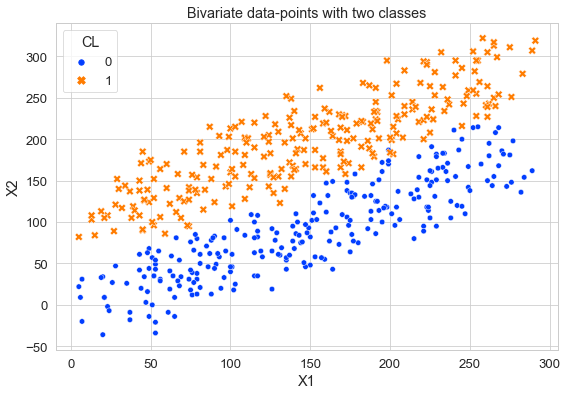

<IPython.core.display.Javascript object>

In [8]:
plt.figure(figsize=(9, 6))

sns.scatterplot(
    data=biv_df,
    x="X1",
    y="X2",
    hue="CL",
    palette="bright",
    style="CL",
    size="CL",
    markers=["o", "X"],
    sizes=(60, 30),
)
plt.title("Bivariate data-points with two classes")

plt.show()

<a id="[3]-Implement-Logistic-Regression"></a>
# [3] Implement Logistic Regression

Implement Logistic Regression with below features:

1. Feature Scaling.
2. Regularization.
3. Auto adjusting Learning rate (α).

#### Conventions

1. $m :=$ Total number of training data-points.
2. $X :=$ Input variables / Features
3. $y :=$ Output variable / Target
4. $(x^{(i)}, y^{(i)}) :=$ $i^{th}$ training data-point.
5. $n :=$ Total number of features in the dataset.

### Hypothesis $h_\theta(x)$

$$ \large h_\theta(x) = \frac{1}{1 + e^{-(\theta^{T} \cdot X^{T})}} \\ $$
$$ \text {Where X is a $m \times n$ matrix and $\vec{\theta}$ is a vector of length n} $$

### Model parameters

$$ \large \theta = \theta_0, \theta_1, \theta_2, \dots, \theta_n $$

### Cost Function $J(\theta)$

$$ \large J(\theta) = \frac{1}{m} \sum_{i = 1}^{m} \text {Cost}\bigl(h_\theta(x^{(i)}), y^{(i)}\bigr) $$

$$
\large
\text {Cost}\bigl(h_\theta(x), y\bigr) =
\begin{cases}
  \hfill -\log\bigl(h_\theta(x)\bigr) \hspace{1cm} \text{if y = 1} \\
  -\log\bigl(1 - h_\theta(x)\bigr) \hspace{1cm} \text{if y = 0} \\
\end{cases}
$$

Combining above two $\text{if}$ conditions into single equation:

$$
\large
J(\theta)=-\frac{1}{m}\sum_{i=1}^{m}\biggl[y^{(i)}\log\bigl(h_\theta(x^{(i)})\bigr)+(1-y^{(i)})\log\bigl(1-h_\theta(x^{(i)})\bigr) \biggr]
$$

### Cost Function $J(\theta)$ with Regularization

$$
\large
J(\theta)=-\frac{1}{m}\sum_{i=1}^{m}\biggl[y^{(i)}\log\bigl(h_\theta(x^{(i)})\bigr)+(1-y^{(i)})\log\bigl(1-h_\theta(x^{(i)})\bigr)\biggr] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_j^{2} \\
$$
$$ \text {Where $\lambda$ is the Regularization parameter} $$

### Goal

$$ \large \min_{\theta} J(\theta) $$

#### Standardization or Z-score Normalization

In [9]:
def standardization(features):
    """
    Function to implement Standardization or Z-score Normalization.
    """
    # Step 1: Compute mean.
    mean = features.mean(axis=0)

    # Step 2: Compute standard-deviation.
    std = features.std(axis=0)

    def transform(sample=features):
        # Step 3: Remove mean from features.
        z_mean = sample - mean

        # Step 4: Scale features to unit-variance.
        zeros = np.zeros_like(sample, dtype="float")
        return np.divide(z_mean, std, out=zeros, where=std != 0)

    return transform

<IPython.core.display.Javascript object>

#### Plot $J(\theta)$ vs No. of Iterations

In [10]:
def plot_cost_vs_itr(points):
    """
    Function to plot J(θ) vs No. of Iterations to
    check if cost is reducing in each iteration.
    """
    count, _ = get_shape(points)
    text(f"Plotting {count} points:")

    x = points[:, 0]
    y = points[:, 1]

    plt.figure(figsize=(10, 6))

    sns.lineplot(x=x, y=y)
    plt.title("Cost vs Iterations")
    plt.xlabel("Number of iterations")
    plt.ylabel("Cost: J(θ)")

    plt.show()

<IPython.core.display.Javascript object>

#### Logistic Regression

In [11]:
def logistic_regression(X, Y, theta=None):
    """
    Function to implement multinomial Logistic Regression
    using Batch Gradient Descent minimization technique.
    """
    LEARNING_RATE = 1
    MAX_ITR = 1000
    PRECISION = 6
    ITR = 100

    """
    By default regularization parameter - 𝜆 - is zero, 
    hence Regularization is "switched off" by default.
    """
    LAMDA = 0  # misspelt to avoid Python keyword `lambda`.

    # Class-labels
    POSITIVE_CLASS_LABEL = 1
    NEGATIVE_CLASS_LABEL = 0

    def preprocess(features):
        """
        Closure to add dummy feature for theta-zero.
        """
        rows, cols = get_shape(features)

        # Add dummy feature X0 for y-intercept into features
        X_0 = np.ones((rows, 1), features.dtype)
        return np.hstack((X_0, features))  # Concatenate horizontally.

    # Preprocessing features.
    X = preprocess(X)

    # Get final shape after preprocessing.
    m, n = get_shape(X)
    # m: Total number of records or data-points
    # n: Total number of input-variables or features.

    # Initialize empty model parameters if not present.
    if not theta:
        theta = np.zeros(n)

    def fit(alpha=LEARNING_RATE, max_itr=MAX_ITR, lamda=LAMDA, nth=ITR, plot_cost=False, precision=PRECISION):
        """
        Fit model parameters(θ) to the dataset i.e., train model using Logistic Regression.
        """
        nonlocal theta

        # Add lambda 0 for dummy feature X0.
        lamdas = [0]
        # Use the provided lambda value for remaining features.
        lamdas[1:] = [lamda] * (n - 1)
        lamdas = np.array(lamdas)
        RC = lamdas / (2 * m)  # Regularization constant.

        title("Logistic Regression")
        text("Model Attributes:")
        text("\tX shape:", get_shape(X))
        text("\tY shape:", get_shape(Y))
        text("\tθ shape:", get_shape(theta))

        def h(X):
            """
            Closure to compute hypothesis using matrix multiplication technique.
            This hypothesis is a Sigmoid function.
            """
            Z = np.matmul(theta, X.transpose())
            return 1 / (1 + np.exp(-Z))

        def get_cost():
            """
            Closure to compute cost of the prediction using hypothesis.
            """
            p_y = h(X).reshape((1, m))  # Predicted Y values.
            p_cls = np.matmul(np.log(p_y), Y)  # Cost w.r.t Positive class.
            n_cls = np.matmul(np.log(1 - p_y), (1 - Y))  # Cost w.r.t Negative class.
            reg_val = np.sum(RC * theta**2)  # Regularization: Penalizing thetas.

            # Compute cost.
            cost = ((-p_cls - n_cls) / m) + reg_val  # Add regularization term to cost.

            return round(cost.item(), precision)

        def gradient_descent(alpha=LEARNING_RATE):
            """
            Closure to compute derivative of Squared Error cost function for
            Gradient Descent algorithm using matrix multiplication technique.
            """
            error = h(X) - Y
            p_theta = lamdas * theta  # Regularization: Penalizing thetas.
            slope = (alpha / m) * (np.matmul(X.transpose(), error) + p_theta)

            # Round off and return updated Theta.
            return np.around(theta - slope, precision)

        text("\nModel training started.")
        table = PrettyTable(["Itr", "Cost", "Model parameters"])
        stack = texts(nth, table)

        costs = []
        for itr in range(0, max_itr):
            j_theta = get_cost()
            theta = gradient_descent(alpha)
            stack(j_theta, theta.tolist())

            # Accumulate iteration count and cost for plotting.
            costs.append([itr, j_theta])

        text(table)
        text("Model training complete!\n")

        if plot_cost:
            plot_cost_vs_itr(np.array(costs))

        def predict(features):
            """
            Closure to predict target value for the given features.
            """
            # Preprocessing features before predicting target.
            pp_f = preprocess(np.array(features, ndmin=2))

            # Predict and return target value.
            y = POSITIVE_CLASS_LABEL if h(pp_f).item() >= 0.5 else NEGATIVE_CLASS_LABEL
            return (y, theta.tolist())

        return predict

    return fit

<IPython.core.display.Javascript object>

<a id="[4]-Training-Model"></a>
# [4] Training Model

#### Feature Scaling

In [12]:
X = biv_df[["X1", "X2"]].values
Y = biv_df["CL"].values

transform = standardization(X)
X = transform()

<IPython.core.display.Javascript object>

#### Initialize Classifier

In [13]:
ENABLE_LOG = True

fit = logistic_regression(X, Y)

<IPython.core.display.Javascript object>

Train model using training dataset.

> Note: Set `ENABLE_LOG` to `False` to train model silently (without logs).

#### Train Classification Model


Logistic Regression

Model Attributes:
	X shape: (500, 3)
	Y shape: (500, None)
	θ shape: (3, None)

Model training started.
+-----+----------+----------------------------------+
| Itr |   Cost   |         Model parameters         |
+-----+----------+----------------------------------+
|  10 | 0.105236 | [0.022337, -3.201876, 5.277718]  |
|  20 | 0.081603 |  [0.02533, -4.035622, 6.481845]  |
|  30 | 0.070861 | [0.027816, -4.611266, 7.311864]  |
|  40 | 0.064365 | [0.030383, -5.063101, 7.962298]  |
|  50 | 0.059887 | [0.033054, -5.440177, 8.504395]  |
|  60 | 0.056555 | [0.035793, -5.766478, 8.972994]  |
|  70 | 0.05395  | [0.038566, -6.055699, 9.387981]  |
|  80 | 0.05184  | [0.041345, -6.316471, 9.761876]  |
|  90 | 0.050085 | [0.044113, -6.554619, 10.103122] |
| 100 | 0.048594 | [0.046859, -6.774275, 10.417705] |
+-----+----------+----------------------------------+
Model training complete!

Plotting 100 points:


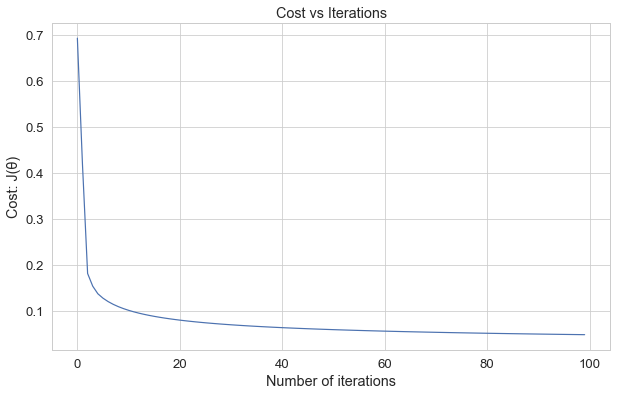

<IPython.core.display.Javascript object>

In [14]:
# Fit Logistic Regression model.
predict = fit(alpha=10, max_itr=100, lamda=0.0001, nth=10, plot_cost=True, precision=6)

<a id="[5]-Testing-Model"></a>
# [5] Testing: Binary Classification

In [15]:
x = [250, 150]
y, model_params = predict(x)

print("Output:")
print("Input features:", x),
print("Predicted class-label:", y)
print(f"Model parameters fit to the dataset:", model_params)

Output:
Input features: [250, 150]
Predicted class-label: 0
Model parameters fit to the dataset: [0.046859, -6.774275, 10.417705]


<IPython.core.display.Javascript object>

In [16]:
x = [150, 200]
y, model_params = predict(x)

print("Output:")
print("Input features:", x),
print("Predicted class-label:", y)
print(f"Model parameters fit to the dataset:", model_params)

Output:
Input features: [150, 200]
Predicted class-label: 1
Model parameters fit to the dataset: [0.046859, -6.774275, 10.417705]


<IPython.core.display.Javascript object>

#### Plotting Model

Model parameters fit to the dataset:

$ \theta = (0.046859, -6.774275, 10.417705) $

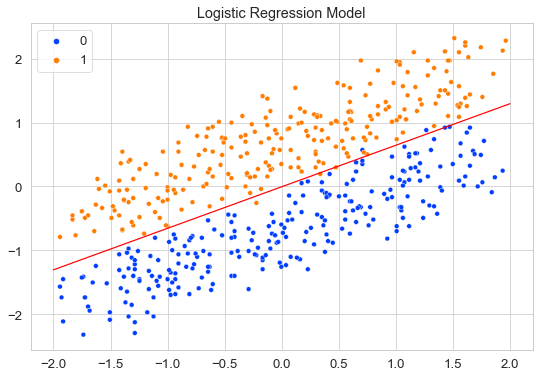

<IPython.core.display.Javascript object>

In [17]:
t0, t1, t2 = model_params

mX = range(-2, 3)
mY = [-(t1 * n + t0) / t2 for n in mX]

plt.figure(figsize=(9, 6))

# Plot Model
sns.lineplot(x=mX, y=mY, color="red")

# Plot Data-points.
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=Y, palette="bright")
plt.title("Logistic Regression Model")

plt.show()